<a href="https://colab.research.google.com/github/SheidaAbedpour/MNIST-Neural-Networks/blob/main/MNIST_MLP_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torch.optim.lr_scheduler import ReduceLROnPlateau

import tensorboard
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# HyperParameters
batch_size = 64
learning_rate = 0.001
num_epochs = 150
lambda_reg = 0.0001

# Load Dataset MNIST:

In [4]:
# MNIS Dataset
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 34783443.82it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1076216.44it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9690370.42it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9389122.11it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# split train_data to validation and train
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

In [6]:
# Load Data
train_data = DataLoader(dataset=train_dataset,
                        batch_size=batch_size,
                        shuffle=True)

test_data = DataLoader(dataset=test_dataset,
                       batch_size=batch_size,
                       shuffle=False)

validation_data = DataLoader(dataset=validation_dataset,
                             batch_size=batch_size,
                             shuffle=False)

In [7]:
# iterate trought the dataloader
for images, lables in train_data:
  print(f'images "{type(images)}" shape: {images.shape}\t,lables "{type(lables)}" shape: {lables.shape}')
  break


'''
images: [128, 1, 28, 28]:
Batch size: 128 images
Channels: 1 (grayscale)
Height: 28 pixels
Width: 28 pixels
'''

images "<class 'torch.Tensor'>" shape: torch.Size([64, 1, 28, 28])	,lables "<class 'torch.Tensor'>" shape: torch.Size([64])


'\nimages: [128, 1, 28, 28]:\nBatch size: 128 images\nChannels: 1 (grayscale)\nHeight: 28 pixels\nWidth: 28 pixels\n'

# Define MLP Architecture

In [8]:
hidden_sizes = [128, 64, 32]

in_features = 28 * 28
out_features = 10

model = nn.Sequential(
    nn.Flatten(),  # images.reshape(-1, 28*28)
    nn.Linear(in_features=in_features, out_features=hidden_sizes[0]),
    nn.ReLU(),
    nn.Linear(in_features=hidden_sizes[0], out_features=hidden_sizes[1]),
    nn.Sigmoid(),
    nn.Linear(in_features=hidden_sizes[1], out_features=hidden_sizes[2]),
    nn.Sigmoid(),
    nn.Linear(in_features=hidden_sizes[2], out_features=out_features)
    # dont apply softmax becuase we'll use crrosEntropyLoss(it applies itself)
)

# Train MLP

In [9]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [10]:
num_batches = len(train_data)  # Number of batches in the training DataLoader

train_losses = []
val_losses = []

convergence_threshold = 1e-6
best_val_loss = float('inf')
patience = 5
wait = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_data):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)
        l2_reg_loss = 0.0
        for param in model.parameters():
          l2_reg_loss += torch.norm(param)**2
        loss += lambda_reg * l2_reg_loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation loop
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
      for images, labels in validation_data:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)
        val_loss += loss.item()

    # check for early stopping
    if (val_loss/len(validation_data)) < best_val_loss:
      best_val_loss = val_loss/len(validation_data)
      wait = 0
    else:
      if ((val_loss/len(train_data)) - best_val_loss) > 1e-3:
        wait += 1
      if wait >= patience:
        print(f'Early Stopped in epohc{epoch+1}/{num_epochs}')
        break

    # check for convergence
    if epoch > 5:
      pre_loss = train_losses[-1]
      if np.abs(pre_loss - running_loss) < convergence_threshold:
        print(f'Convergence in epoch{epoch}/{num_epochs}')
        break

    current_lr = optimizer.param_groups[0]['lr']

    print(f'Epoch {epoch+1}/{num_epochs}: Training Loss: {running_loss/len(train_data):.4f}, Validation Loss: {val_loss/len(validation_data):.4f}, lr:{current_lr}')
    train_losses.append(running_loss)
    val_losses.append(val_loss)

    # Update the learning rate
    scheduler.step(running_loss/len(train_data))

print("Training finished")

Epoch 1/150: Training Loss: 0.9938, Validation Loss: 0.3365, lr:0.001
Epoch 2/150: Training Loss: 0.3020, Validation Loss: 0.1800, lr:0.001
Epoch 3/150: Training Loss: 0.2179, Validation Loss: 0.1479, lr:0.001
Epoch 4/150: Training Loss: 0.1855, Validation Loss: 0.1246, lr:0.001
Epoch 5/150: Training Loss: 0.1661, Validation Loss: 0.1127, lr:0.001
Epoch 6/150: Training Loss: 0.1537, Validation Loss: 0.1079, lr:0.001
Epoch 7/150: Training Loss: 0.1442, Validation Loss: 0.1026, lr:0.001
Epoch 8/150: Training Loss: 0.1374, Validation Loss: 0.1007, lr:0.001
Epoch 9/150: Training Loss: 0.1314, Validation Loss: 0.1002, lr:0.001
Epoch 10/150: Training Loss: 0.1283, Validation Loss: 0.0978, lr:0.001
Epoch 11/150: Training Loss: 0.1272, Validation Loss: 0.0884, lr:0.001
Epoch 12/150: Training Loss: 0.1212, Validation Loss: 0.0948, lr:0.001
Epoch 13/150: Training Loss: 0.1201, Validation Loss: 0.0902, lr:0.001
Epoch 14/150: Training Loss: 0.1202, Validation Loss: 0.0997, lr:0.001
Epoch 15/150: T

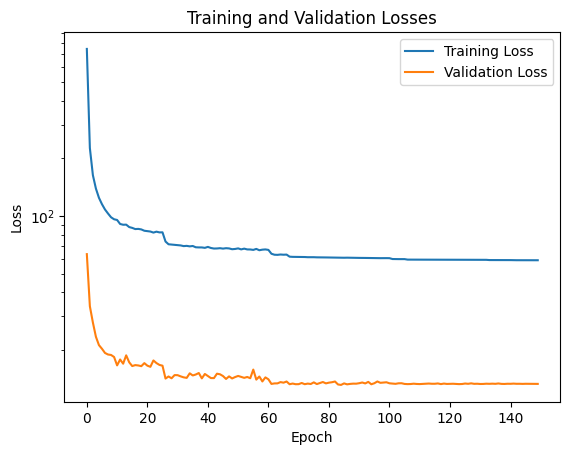

In [11]:
# Plot the training and validation losses with a logarithmic scale
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.yscale('log')
plt.legend()
plt.show()

In [12]:
# Test and Evaluate Model

model.eval()

true_labels = []
predicted_labels = []
total = 0
correct = 0

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, lables in test_data:
        images, lables = images.to(device), lables.to(device)

        # Forward pass
        outputs = model(images)

        # Get the predicted class
        _, predicted = torch.max(outputs, dim=1)

        total += lables.shape[0]
        correct += (predicted == lables).sum().item()

        true_labels.extend(lables.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

print(f'Accuracy of the model on the test images: {100 * correct / total} %')

Accuracy of the model on the test images: 98.01 %


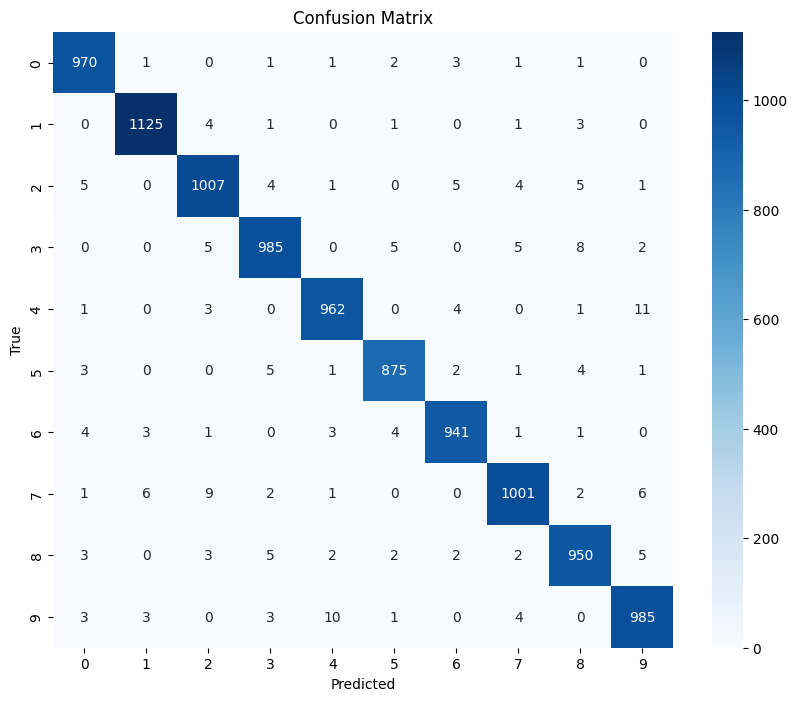

In [13]:
# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()